In [2]:
!pip install matplotlib seaborn scikit-learn pandas numpy

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 4.8 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 6.2 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 7.3 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 7.6 MB/s  0:00:01
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 10.6 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --------------- ------------------------ 2.6/7.0 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------  6.8/7.0 MB 16.2 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 15.2 MB/s  0:00:00

   ----------------------------------

In [7]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [8]:
#Load Raw Data
# ==============================
file_path = r"C:\Users\F8eee\Downloads\Trafficproject.csv"


In [9]:
# Some CSVs contain special characters, so we use latin1 encoding
df = pd.read_csv(file_path, encoding='latin1')

In [10]:
# Rename Temperature column for easier access
df.rename(columns={'Temperature (°C)': 'Temperature_C'}, inplace=True)

In [12]:
# Convert DateTime column to proper datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d-%m-%Y %H:%M")
print("✅ Raw Data Loaded")
print(df.head())
print(df.info())

✅ Raw Data Loaded
             DateTime  Junction  Vehicles           ID  Temperature_C  Rain  \
0 2015-11-01 00:00:00         1        15  20151101001             26     0   
1 2015-11-01 01:00:00         1        13  20151101011             29     0   
2 2015-11-01 02:00:00         1        10  20151101021             28     0   
3 2015-11-01 03:00:00         1         7  20151101031             26     0   
4 2015-11-01 04:00:00         1         9  20151101041             29     0   

   IsEvent  IsWeekend  
0        0          0  
1        0          1  
2        0          0  
3        1          0  
4        1          1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       48120 non-null  datetime64[ns]
 1   Junction       48120 non-null  int64         
 2   Vehicles       48120 non-null  int64         


In [20]:
# Handle missing values (forward fill, since time series)
df = df.ffill()

# Remove duplicates
df = df.drop_duplicates()

# Make sure DateTime is the index (only if not already set)
if 'DateTime' in df.columns:
    df = df.set_index('DateTime')

In [21]:
# Aggregate Hourly Data
# ==============================
# Already hourly data, but we enforce grouping to avoid mismatches
df_hourly = df.groupby('Junction').resample('H').agg({
    'Vehicles': 'sum',
    'Temperature_C': 'mean',
    'Rain': 'mean',
    'IsEvent': 'max',
    'IsWeekend': 'max'
}).reset_index()

print("✅ Aggregated Data")
print(df_hourly.head())


✅ Aggregated Data
   Junction            DateTime  Vehicles  Temperature_C  Rain  IsEvent  \
0         1 2015-11-01 00:00:00        15           26.0   0.0        0   
1         1 2015-11-01 01:00:00        13           29.0   0.0        0   
2         1 2015-11-01 02:00:00        10           28.0   0.0        0   
3         1 2015-11-01 03:00:00         7           26.0   0.0        1   
4         1 2015-11-01 04:00:00         9           29.0   0.0        1   

   IsWeekend  
0          0  
1          1  
2          0  
3          0  
4          1  


C:\Users\F8eee\AppData\Local\Temp\ipykernel_12320\1931804850.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.groupby('Junction').resample('H').agg({


In [22]:
# Step 5: Preprocessing (Normalization)
# ==============================
scaler = StandardScaler()
df_hourly[['Vehicles','Temperature_C','Rain']] = scaler.fit_transform(
    df_hourly[['Vehicles','Temperature_C','Rain']]
)

print("✅ Normalized Data")
print(df_hourly.head())

✅ Normalized Data
   Junction            DateTime  Vehicles  Temperature_C  Rain  IsEvent  \
0         1 2015-11-01 00:00:00 -0.375489      -0.880972   0.0        0   
1         1 2015-11-01 01:00:00 -0.471875       0.877343   0.0        0   
2         1 2015-11-01 02:00:00 -0.616454       0.291238   0.0        0   
3         1 2015-11-01 03:00:00 -0.761034      -0.880972   0.0        1   
4         1 2015-11-01 04:00:00 -0.664648       0.877343   0.0        1   

   IsWeekend  
0          0  
1          1  
2          0  
3          0  
4          1  


In [23]:
# Step 6: Feature Engineering
# ==============================
# Time-based features
df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.dayofweek
df_hourly['Month'] = df_hourly['DateTime'].dt.month

# Lag features (previous 1, 3, 6 hours traffic volume)
for lag in [1, 3, 6]:
    df_hourly[f'Lag_{lag}h'] = df_hourly.groupby('Junction')['Vehicles'].shift(lag)

# Drop NaN rows caused by lagging
df_hourly = df_hourly.dropna()

print("✅ Feature Engineering Done")
print(df_hourly.head())

✅ Feature Engineering Done
    Junction            DateTime  Vehicles  Temperature_C  Rain  IsEvent  \
6          1 2015-11-01 06:00:00 -0.664648       0.291238   0.0        0   
7          1 2015-11-01 07:00:00 -0.712841      -0.294867   0.0        0   
8          1 2015-11-01 08:00:00 -0.568261      -0.880972   0.0        0   
9          1 2015-11-01 09:00:00 -0.520068      -0.880972   0.0        1   
10         1 2015-11-01 10:00:00 -0.375489      -1.467077   0.0        1   

    IsWeekend  Hour  DayOfWeek  Month    Lag_1h    Lag_3h    Lag_6h  
6           0     6          6     11 -0.809227 -0.761034 -0.375489  
7           0     7          6     11 -0.664648 -0.664648 -0.471875  
8           0     8          6     11 -0.712841 -0.809227 -0.616454  
9           0     9          6     11 -0.568261 -0.664648 -0.761034  
10          1    10          6     11 -0.520068 -0.712841 -0.664648  


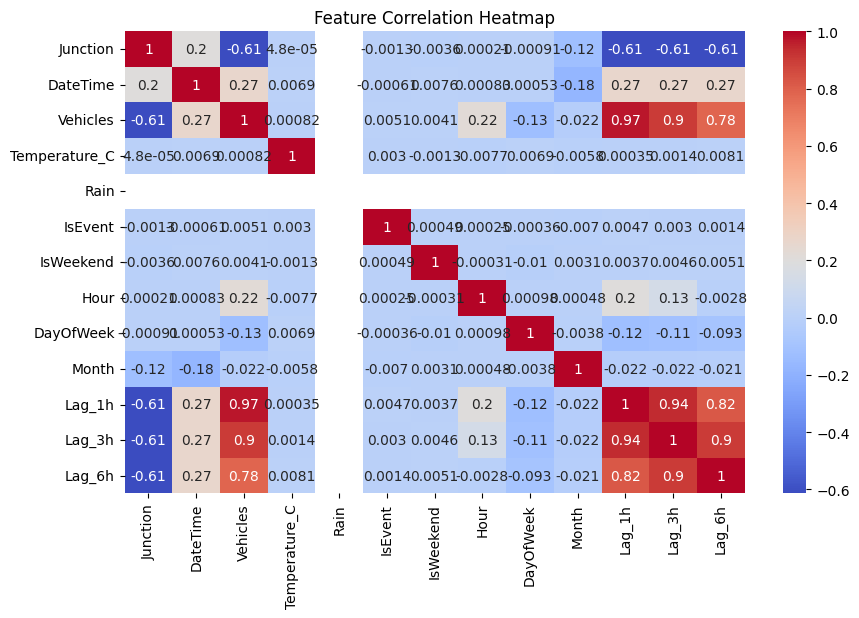

✅ Feature Importance
          Feature  Importance
8          Lag_1h    0.944360
5            Hour    0.019581
9          Lag_3h    0.009611
10         Lag_6h    0.008146
7           Month    0.005268
6       DayOfWeek    0.004464
1   Temperature_C    0.003309
0        Junction    0.002998
4       IsWeekend    0.001191
3         IsEvent    0.001073
2            Rain    0.000000


In [24]:
# Step 7: Feature Selection
# ==============================
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_hourly.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature importance with Random Forest
X = df_hourly.drop(['Vehicles','DateTime'], axis=1)
y = df_hourly['Vehicles']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("✅ Feature Importance")
print(feature_importance)

In [25]:
# Step 8: Save Processed Data
# ==============================
output_path = r"C:\Users\F8eee\Downloads\Trafficproject_processed.csv"
df_hourly.to_csv(output_path, index=False)

print(f"✅ Processed dataset saved at: {output_path}")

✅ Processed dataset saved at: C:\Users\F8eee\Downloads\Trafficproject_processed.csv
